<a href="https://colab.research.google.com/github/Sourjya261/IDRid_EX_Segmentation/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Crop + Gaussian Blur

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IDRiD_02.jpg
(2848, 4288, 3)
(2848, 3413, 3)
height_offset 0
width_offset 272



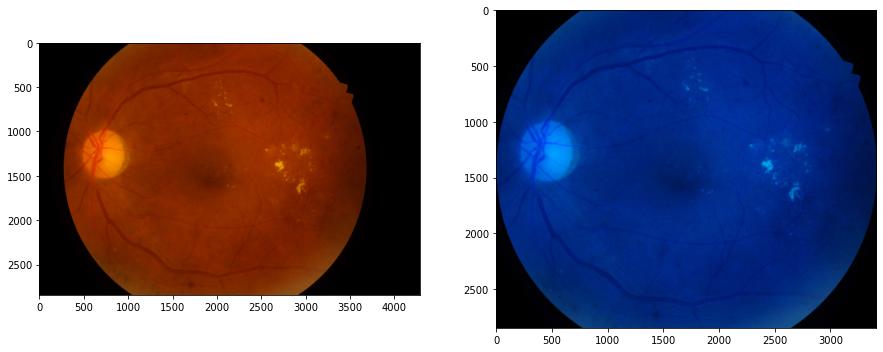

IDRiD_01.jpg
(2848, 4288, 3)
(2848, 3481, 3)
height_offset 0
width_offset 255



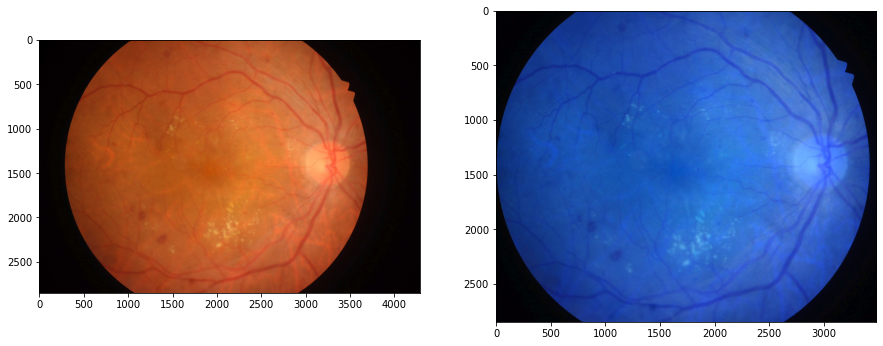

IDRiD_03.jpg
(2848, 4288, 3)
(2848, 3416, 3)
height_offset 0
width_offset 272



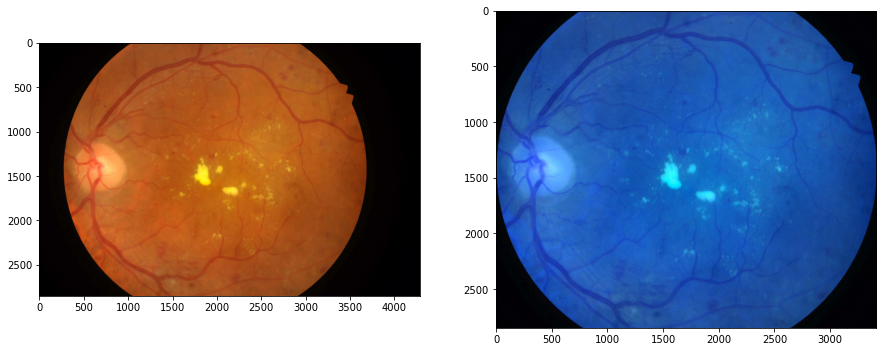

IDRiD_04.jpg
(2848, 4288, 3)
(2848, 3801, 3)
height_offset 0
width_offset 104



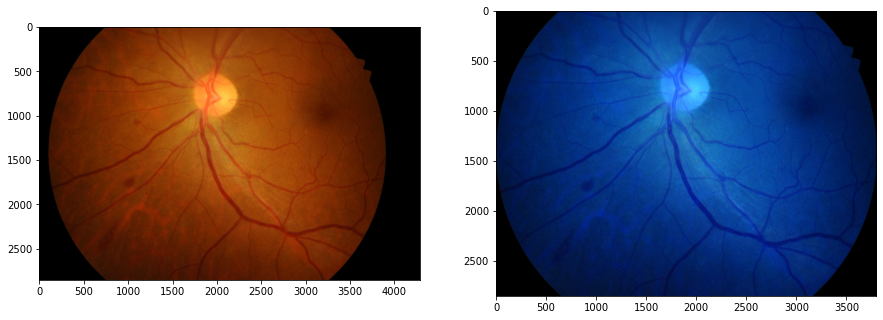

IDRiD_05.jpg
(2848, 4288, 3)
(2848, 3434, 3)
height_offset 0
width_offset 272



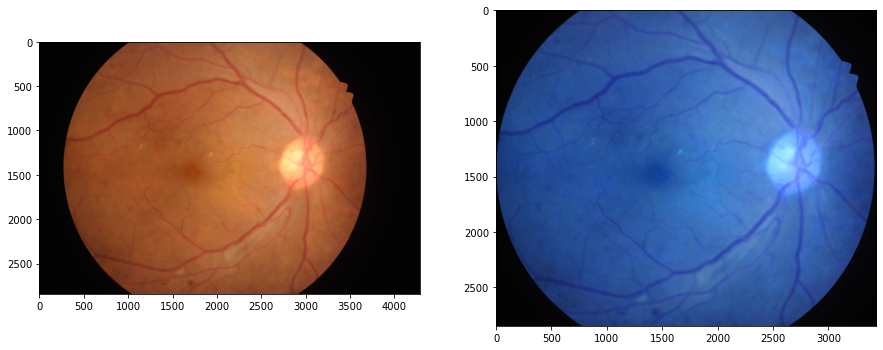

In [ ]:
import os
from scipy import ndimage
import cv2
import numpy as np
import matplotlib.pyplot as plt
def crop_image_from_gray(img, tol=10):
    dims = img.ndim

    if dims == 3:
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif dims == 2:
        gray_image = img

    mask = gray_image > tol

    # find start crop point
    objs = ndimage.find_objects(mask)
    height_offset = objs[0][0].start
    width_offset = objs[0][1].start

    # plt.imshow(mask, cmap="gray")
    # plt.axvline(x=width_offset)
    # plt.axhline(y=height_offset)
    # plt.show()

    ix = np.ix_(mask.any(1),mask.any(0))

    if dims == 2:
        return img[ix], height_offset, width_offset
    
    check_shape = img[:,:,0][ix].shape[0]
    if (check_shape == 0): # image is too dark so that we crop out everything,
        return img, 0, 0 # return original image

    img1 = img[:,:,0][ix]
    img2 = img[:,:,1][ix]
    img3 = img[:,:,2][ix]
    img = np.stack([img1, img2, img3],axis=-1)

    return img, height_offset, width_offset
def circle_crop(img, sigmaX=50):   
    """
    Create circular crop around image centre    
    """
    img, height_offset, width_offset = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img, height_offset, width_offset

src_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/Images_train'

samples = 5

for i, im in enumerate(os.listdir(src_dir)[:samples]):
    print(im)
    img = cv2.imread(os.path.join(src_dir, im))
    height, width, depth = img.shape
    img_t, height_offset, width_offset = circle_crop(img, 50)
    print(img.shape)
    print(img_t.shape)
    print("height_offset", height_offset)
    print("width_offset", width_offset)
    print()

    f, axarr = plt.subplots(1,2, figsize=(15,11))
    axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))
    plt.show()

Svng to disk

In [ ]:
src_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/Images_train/'
out_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/Images_train_cropped/'
offsets_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/cropnblur_offsets/'

os.makedirs(out_dir, exist_ok=True)
os.makedirs(offsets_dir, exist_ok=True)

for im in os.listdir(src_dir):
    print(im)
    img = cv2.imread(os.path.join(src_dir, im))

    height, width, _ = img.shape

    img_t, height_offset, width_offset = circle_crop(img, sigmaX=50)

    cv2.imwrite(os.path.join(out_dir, im), cv2.cvtColor(img_t, cv2.COLOR_RGB2BGR))

    new_height, new_width, _ = img_t.shape

    with open(os.path.join(offsets_dir, im[:-4]+"_offset.txt"), 'w') as f:
        f.write("{} {} {} {} {} {}\n".format(height, width, height_offset, width_offset, new_height, new_width))

In [ ]:
from tqdm import tqdm
images_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/images/'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/Masks_train/3. Hard Exudates/'
offsets_dir = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/cropnblur_offsets/"
out_dir = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/masks/"

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
for image_name in tqdm(os.listdir(images_dir)):
    image_name = image_name[:-4]
    with open(os.path.join(offsets_dir, image_name+ '_offset'+".txt"), 'r') as f:
        offsets = list(map(int, f.readline().split()))
    
    image = cv2.imread(os.path.join(images_dir, image_name+".jpg"))
    mask = cv2.imread(os.path.join(masks_dir, image_name+ "_EX"+ ".tif"))
    new_mask = mask[offsets[2]:offsets[2]+offsets[4], offsets[3]:offsets[3]+offsets[5]]

    cv2.imwrite(os.path.join(out_dir, image_name+".tif"), new_mask)

100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


In [ ]:
import cv2
from tqdm import tqdm

path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
img_save_path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/images_aug/"
mask_save_path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/masks_aug/"
images = sorted(os.listdir(os.path.join(path,"images/")))

for img in tqdm(images):
  name = img.split(".")[0]
  img = cv2.imread(os.path.join(path+'images',img))
  mask = cv2.imread(os.path.join(path+"masks",name+'.tif'))
  cv2.imwrite(os.path.join(img_save_path,name+'.jpg'), img)
  cv2.imwrite(os.path.join(mask_save_path,name+'.tif'), mask)
  img_flip_ud = cv2.flip(img, 0)
  mask_flip_ud = cv2.flip(mask,0)
  cv2.imwrite(os.path.join(img_save_path,name+'ud'+'.jpg'), img_flip_ud)
  cv2.imwrite(os.path.join(mask_save_path,name+'ud'+'.tif'), mask_flip_ud)
  img_flip_lr = cv2.flip(img, 1)
  mask_flip_lr = cv2.flip(mask,1)
  cv2.imwrite(os.path.join(img_save_path,name+'lr'+'.jpg'), img_flip_lr)
  cv2.imwrite(os.path.join(mask_save_path,name+'lr'+'.tif'), mask_flip_lr)
  img_flip_ud_lr = cv2.flip(img, -1)
  mask_flip_ud_lr = cv2.flip(mask,-1)
  cv2.imwrite(os.path.join(img_save_path,name+'ud_lr'+'.jpg'), img_flip_ud_lr)
  cv2.imwrite(os.path.join(mask_save_path,name+'ud_lr'+'.tif'), mask_flip_ud_lr)
  

100%|██████████| 54/54 [03:21<00:00,  3.72s/it]


"\nimg = cv2.imread('data/src/lena.jpg')\nprint(type(img))\n# <class 'numpy.ndarray'>\n\nprint(img.shape)\n# (225, 400, 3)\n\nimg_flip_ud = cv2.flip(img, 0)\ncv2.imwrite('data/dst/lena_cv_flip_ud.jpg', img_flip_ud)\n# True\n\nimg_flip_lr = cv2.flip(img, 1)\ncv2.imwrite('data/dst/lena_cv_flip_lr.jpg', img_flip_lr)\n# True\n\nimg_flip_ud_lr = cv2.flip(img, -1)\ncv2.imwrite('data/dst/lena_cv_flip_ud_lr.jpg', img_flip_ud_lr)\n# True\n"